## <span style="color:orange">Use Case: Co-locate satellite and in-situ data for cross-validation</span>

#### User Story
As a coastal applications researcher, I would like to co-locate in-situ measurements and satellite data near the European coast for cross-validation of data or model validation, during the winter of 2019. (*Note: this user stroes was developed to demo at the 2nd Annual SWOT Applications Early Adopter Hackweek, 8 March 2021.)

#### Learning Objectives
- Co-locate remote sensing data from the Earthdata Cloud archive with in-situ measurements from another provider, programmatically using the Earthdata CMR amd Harmony APIs. 
- Workflow can be conducted either locally or in the cloud (i.e. it is compute environment agnostic). 
- While capabilities demoed here are shown through an oceanography example, these use cases and examples can be applied as building blocks for developing other user workflows with PO.DAAC and Earthdata datasets, across a range of science and applications disciplines, including for example terrestrial hydrology, coastal, or cryosphere. 
- Note: Searching for NASA Earthdata data given point-based observation locations can also be done via the NASA Earthdata Search user interface https://search.earthdata.nasa.gov/search, in addition to programmatically (as shown here).

#### Datasets used
- Argo floats https://argo.ucsd.edu/
- MODIS-Aqua L2 SST https://podaac.jpl.nasa.gov/dataset/AMSRE-REMSS-L2P-v7a
- MUR L4 SST https://registry.opendata.aws/mur/

#### Main Steps in Workflow
1. Define study region and period of time of interest: Atlantic Ocean west of Portugal and Morocco, January 2019
2. Get in-situ Argo floats using the Argo API and prepapre the Argo data (select Argo SST for one float during its journey in Jan 2019 at the top pressure level i.e. nearest the ocean surface)
3. Get coincident SST observed by the MODIS satellite, from the NASA Earthdata Cloud (in AWS)
    - Search Earthdata Cloud satellite data for collection of interest (MODIS-Aqua L2) (using the CMR API)
    - Extract satellite data at the in-situ location for direct comparison (using the Harmony API)
    - Download locally (from the cloud archive), or download to your cloud storage or compute space if working within the AWS cloud
    - Quality control the MODIS data with daytime and quality flag filters    
4. Plot time series comparing the in-situ and satellite data at in-situ location(s)
5. Validate with a third dataset, MUR L4 SST (once version stored in the *AWS Registry of Open Data* - public data access)

*Note: in order to currently access PO.DAAC Cloud Pathfinder datasets such as MODIS SST L2 from the Earthdata Cloud, your Earthdata login username needs to be added to an restrcited early access list (during the transition period of migrating PO.DAAC data to the Earthdata Cloud). Please contact podaac@podaac.jpl.nasa.gov to make that request.*

<img src="browse.png" />

---------------

### Requirements

**Import modules**: The Python ecosystem is organized into modules.  A module must be imported before the contents of that modules can be used.  It is good practice to import modules in the first code cell of a notebook or at the top of your script.  Not only does this make it clear which modules are being used, but it also ensures that the code fails at the beginning because one of the modules is not installed rather half way through after crunching a load of data.

For some modules, it is common practice to shorten the module names according to accepted conventions.  For example, the plotting module `matplotlib.pyplot` is shortened to `plt`.  It is best to stick to these conventions rather than making up your own short names so that people reading your code see immediately what you are doing. 

In [1]:
from tqdm import tqdm
from datetime import datetime
from folium.plugins import MarkerCluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import requests
import warnings
import os.path
import folium
import json
import time
tqdm.pandas()

matplotlib.rc('font', family="sans-serif", weight="normal", size=16)

!mkdir -p resources/

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

**User note:** You must set up a local netrc file to run the notebook to completion. Write a file like this into your home directory:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 

### Study region and period

Set some "master" inputs to define the time and place contexts for our case studies in the ipynb. 

In [2]:
start_date  = "2019-01-01"
end_date    = "2019-01-31"
aoi_lon_min = -26.0
aoi_lat_min =  30.0
aoi_lon_max = -12.0
aoi_lat_max =  40.0

Plot the spatial extent of our study area with a white rectangle bounding box:

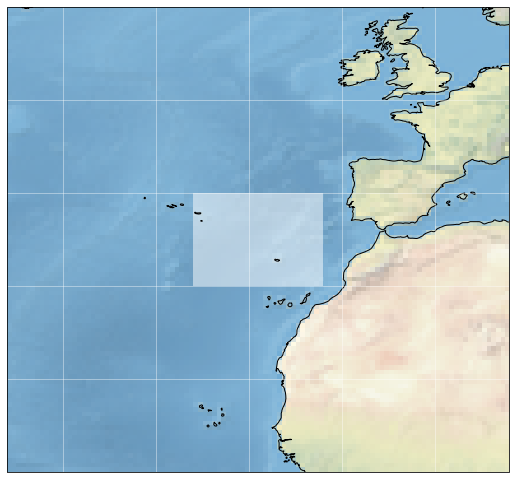

In [3]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.figure.set_figheight(9)
ax.figure.set_figwidth(9)
ax.add_patch(mpatches.Rectangle(xy=[aoi_lon_min, aoi_lat_min], 
                                width=aoi_lon_max-aoi_lon_min, 
                                height=aoi_lat_max-aoi_lat_min,
                                facecolor='white',
                                alpha=0.5,
                                transform=ccrs.Geodetic()))
ax.set_extent((aoi_lon_min-20., 
               aoi_lon_max+20.,
               aoi_lat_min-20.,
               aoi_lat_max+20.), crs=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(color="white", alpha=0.5)
plt.show()

## Access temperature profiles from ArgoVis API

ArgoVis is an API and visualization service that provides access to Argo float profiles. The endpoint for requesting profile data is given in the cell below:

In [4]:
argo_api = 'https://argovis.colorado.edu/selection/profiles/?'

print(argo_api)

https://argovis.colorado.edu/selection/profiles/?


Create the AOI polygon in required XY format, make it a string, and collect the dictionary of API parameters:

In [5]:
argo_aoi = [[[aoi_lon_min, aoi_lat_min], 
             [aoi_lon_min, aoi_lat_max], 
             [aoi_lon_max, aoi_lat_max],
             [aoi_lon_max, aoi_lat_min],
             [aoi_lon_min, aoi_lat_min]]]

argo_par = {'startDate': start_date.replace("-0","-"),
            'endDate': end_date.replace("-0","-"),
            'shape': str(argo_aoi).replace(" ","")}

argo_par

{'startDate': '2019-1-1',
 'endDate': '2019-1-31',
 'shape': '[[[-26.0,30.0],[-26.0,40.0],[-12.0,40.0],[-12.0,30.0],[-26.0,30.0]]]'}

Submit the request parameters to the Argovis API. You should receive a JSON response back. Print the number of profiles inside our AOI:

In [6]:
argo_response = requests.get(url=argo_api, params=argo_par)

if argo_response.status_code == 200:
    argo_profiles = argo_response.json()
    print(len(argo_profiles))
else:
    print(argo_response.text)

41


### Prepare profile data for further analysis

Concatenate the list of metadata dictionaries returned for the argos into a table and update a few of its columns with Pythonic types:

In [7]:
argo_df = pd.DataFrame(argo_profiles).sort_values("date")
argo_df['datetime'] = pd.to_datetime(argo_df.date)
argo_df['date'] = argo_df.datetime.apply(lambda x: x.date).tolist()
argo_df['lat'] = argo_df.roundLat.astype(float)
argo_df['lon'] = argo_df.roundLon.astype(float)

argo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 40 to 0
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   _id                           41 non-null     object             
 1   POSITIONING_SYSTEM            41 non-null     object             
 2   DATA_CENTRE                   41 non-null     object             
 3   PI_NAME                       41 non-null     object             
 4   WMO_INST_TYPE                 41 non-null     object             
 5   VERTICAL_SAMPLING_SCHEME      41 non-null     object             
 6   DATA_MODE                     41 non-null     object             
 7   PLATFORM_TYPE                 41 non-null     object             
 8   measurements                  41 non-null     object             
 9   station_parameters            41 non-null     object             
 10  pres_max_for_TEMP             41 non-nul

You can download profiles in netCDF format from the FTP link stored in the *nc_url* fields of the response. Here's the URL for the first of the profiles:

In [8]:
print(argo_df.iloc[0].nc_url)

ftp://ftp.ifremer.fr/ifremer/argo/dac/coriolis/6902663/profiles/R6902663_124.nc


Display a table summarizing the space/time characteristics of eaach profile:

In [9]:
argo_df['date'] = argo_df.datetime.apply(lambda x: x.date)
argo_df['time'] = argo_df.datetime.apply(lambda x: x.time)

argo_df[['platform_number', 'cycle_number', 'datetime', 'lon', 'lat']]

,platform_number,cycle_number,datetime,lon,lat
40,6902663,124,2019-01-01 20:14:00+00:00,-17.383,35.601
39,6901260,49,2019-01-02 05:43:00+00:00,-12.812,37.707
38,6901143,228,2019-01-02 09:22:20+00:00,-21.083,32.254
37,6902664,124,2019-01-02 20:28:00+00:00,-18.411,34.985
36,3901643,43,2019-01-04 06:13:00+00:00,-22.429,37.556
35,3901942,48,2019-01-05 20:23:30+00:00,-15.286,35.316
34,6901262,22,2019-01-06 05:42:59.999000+00:00,-17.967,34.228
33,3901932,22,2019-01-06 05:49:00+00:00,-19.904,33.428
32,1901688,288,2019-01-07 03:11:53+00:00,-23.134,34.258
31,6901260,50,2019-01-07 05:26:00+00:00,-12.887,37.905


*Now plot argo profile locations on an interactive map.*

This plot uses folium/leaflet. Hover/click the clusters (which correspond to specific Argo float platforms) to zoom to the groups of individual profiles and display metadata about them:

In [10]:
def _get_tooltip(profile: dict):
    return """<b>Date</b>: {date}<br>
              <b>Profile ID</b>: {_id}<br>
              <b>Platform ID</b>: {platform_number}<br>
              <b>Latitude</b>: {lat}<br>
              <b>Longitude</b>: {lon}<br>""".format(**profile)


m = folium.Map(location=[argo_df['lat'].mean(), argo_df['lon'].mean()], 
               tiles="Stamen Terrain",
               zoom_start=5, )

unique_argo_platform_numbers = argo_df.platform_number.unique().tolist()

for i, platform in enumerate(unique_argo_platform_numbers):

    # Get row(s) for the current platform
    p = argo_df[argo_df['platform_number']==platform]
    
    # Make an empty marker cluster to add to the map widget
    cluster = MarkerCluster(name=p['platform_number'])
    
    # Make markers in a loop and add to the cluster:
    for c in p['cycle_number'].tolist():
        
        # Select the row for the current profile ('cycle')
        profile = p[p['cycle_number']==c].iloc[0]
        
        # Create a new marker and add it to the cluster
        cluster.add_child(folium.Marker(
            location=[profile['lat'], profile['lon']],
            tooltip=_get_tooltip(profile.to_dict())))
    
    m.add_child(cluster)

display(m)

#### Reformat profile data into data frames

The in situ measurements temperature, pressure, and salinity readings collected during each profile are returned inside the JSON response.

The format of the *measurements* field is perfect for conversion to *pandas* data frames. Apply *pandas.DataFrame* over the entire measurements column to make a pandas.Series of data frames, and replace the existing content in the *measurements* column:

In [11]:
argo_df['measurements'] = argo_df['measurements'].apply(pd.DataFrame).tolist()

argo_df.iloc[0].measurements.describe()

,temp,pres,psal
count,105.000000,105.000000,105.000000
mean,11.579429,794.390476,35.832990
std,4.726514,655.512828,0.433002
min,4.053000,6.000000,35.073000
25%,8.096000,146.000000,35.597000
50%,10.885000,713.000000,35.765000
75%,15.750000,1363.000000,36.128000
max,18.418000,2010.000000,36.504000


**Plot temperature at the minimum pressure for each profile**

This cell applies a lambda over the measurements column to slice the row corresponding to the minimum pressure bin for each profile and returns the corresponding temperature measurement:

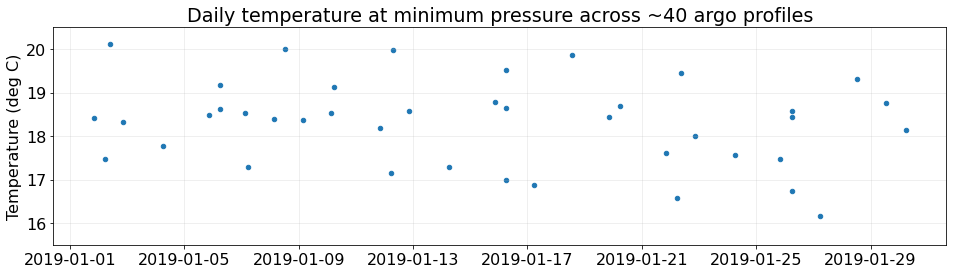

In [12]:
def get_prof_temp_at_min_pres(x):
    return x[x.pres==x.pres.min()].temp.item()

argo_df['temp_at_pres_min'] = argo_df.measurements.apply(get_prof_temp_at_min_pres)

argo_df.plot.scatter(x="datetime", y="temp_at_pres_min", figsize=(16, 4))
plt.title("Daily temperature at minimum pressure across ~40 argo profiles")
plt.ylabel("Temperature (deg C)")
plt.xlabel(None)
plt.ylim(15.5,20.5)
plt.grid(alpha=0.25)

#### Select an *Argo of Interest* and its *platform_number*

See which floats had the most profiles within our timeframe/area of interest:

In [13]:
argo_df.groupby("platform_number").count().cycle_number

platform_number
1901688    6
3901643    3
3901932    3
3901942    3
6901143    3
6901260    6
6901262    3
6901273    3
6902552    3
6902663    3
6902664    3
6902785    2
Name: cycle_number, dtype: int64

Choose a float with six profiles to study further during the remainder of the notebook. Take a peek at the relevant data from the target Argo float platform across six profiles:

In [14]:
argo_skinny = argo_df[argo_df.platform_number==6901260].copy()

argo_skinny[['_id', 'date', 'time', 'lat', 'lon', 'temp_at_pres_min']]

,_id,date,time,lat,lon,temp_at_pres_min
39,6901260_49,2019-01-02,05:43:00,37.707,-12.812,17.479
31,6901260_50,2019-01-07,05:26:00,37.905,-12.887,17.300
24,6901260_51,2019-01-12,05:18:00,38.047,-12.982,17.153
16,6901260_52,2019-01-17,05:28:00,38.266,-13.092,16.875
11,6901260_53,2019-01-22,05:33:00,38.378,-13.146,16.566
3,6901260_54,2019-01-27,05:38:00,38.484,-13.265,16.153


## Access *sea surface temperature* from MODIS

The user guide for MODIS Level 2 Sea Surface Temperature (SST) from GHRSST is available on the PO.DAAC Drive:    
https://podaac-tools.jpl.nasa.gov/drive/files/OceanTemperature/ghrsst/docs/GDS20r5.pdf

The API requires a dataset identifier that we must obtain from CMR. In the next cell, submit a request to the CMR API to grab the metadata for to the dataset/collection.

In [15]:
url = "https://cmr.earthdata.nasa.gov/search/collections.umm_json"

params = dict(provider="POCLOUD", ShortName="MODIS_A-JPL-L2P-v2019.0")

modis = requests.get(url, params).json().get('items')[0]

type(modis), list(modis)

(dict, ['meta', 'umm'])

Select the collection's unique *concept-id* from the *meta* object:

In [16]:
ccid = modis.get('meta').get('concept-id')

print(ccid)

C1940473819-POCLOUD


**Redefine the AOI to the minimum XY bounds of selected profiles**

Simply replace the *`aoi_*`* Python variables with min/max of the *lat* and *lon* columns in the new *argo_skinny* data frame:

In [17]:
aoi_lon_min = argo_skinny.lon.min()
aoi_lon_max = argo_skinny.lon.max()
aoi_lat_min = argo_skinny.lat.min()
aoi_lat_max = argo_skinny.lat.max()

aoi_lon_min, aoi_lon_max, aoi_lat_min, aoi_lat_max

(-13.265, -12.812, 37.707, 38.484)

#### Request subsets from the Harmony API

We will submit two requests to the [Harmony API](https://harmony.earthdata.nasa.gov/). Please note that the API is under active development, we recommend testing input parameters using the [Swagger API interface](https://harmony.earthdata.nasa.gov/docs/api/#).

In [18]:
harmony_url = "https://harmony.earthdata.nasa.gov"

Make two dictionaries of subset parameters. *Note that we need to submit two requests to get the whole month.*

In [19]:
params = {
    'lat':  f'({aoi_lat_min}:{aoi_lat_max})', 
    'lon':  f'({aoi_lon_min}:{aoi_lon_max})', 
    'time': f'("{start_date}T00:00:00.000Z":"{end_date}T23:59:59.999Z")',
}

print(json.dumps(params, indent=2))

{
  "lat": "(37.707:38.484)",
  "lon": "(-13.265:-12.812)",
  "time": "(\"2019-01-01T00:00:00.000Z\":\"2019-01-31T23:59:59.999Z\")"
}


#### Submit the request parameters to the Harmony API endpoint

Format the parameters dictionary as a string to make a query string and append it to the Harmony API endpoint. Then, submit the request and store the response to a variable `job`.

In [20]:
endpoint = f"{harmony_url}/{ccid}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset"

query = "subset=time{time}&subset=lat{lat}&subset=lon{lon}".format(**params)

with requests.get(f"{endpoint}?{query}") as response:
    job = response.json()

print(json.dumps(job, indent=2))

{
  "username": "jmcnelis",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2021-12-07T06:06:13.930Z",
  "updatedAt": "2021-12-07T06:06:13.930Z",
  "links": [
    {
      "href": "https://harmony.earthdata.nasa.gov/jobs/f95ae632-9155-41c2-a6f9-5d0cf92a6f6a?page=1&limit=2000",
      "title": "The current page",
      "type": "application/json",
      "rel": "self"
    }
  ],
  "request": "https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time(%222019-01-01T00%3A00%3A00.000Z%22%3A%222019-01-31T23%3A59%3A59.999Z%22)&subset=lat(37.707%3A38.484)&subset=lon(-13.265%3A-12.812)",
  "numInputGranules": 106,
  "jobID": "f95ae632-9155-41c2-a6f9-5d0cf92a6f6a"
}


The first link in the list of *links* in the response will respond with the json shown above. Set it to a python variable called `job_url`:

In [21]:
job_url = job.get("links")[0].get("href")

print(job_url)

https://harmony.earthdata.nasa.gov/jobs/f95ae632-9155-41c2-a6f9-5d0cf92a6f6a?page=1&limit=2000


**Monitor status of the in-progress job**

Run the next cell to monitor the status of the request.

In [22]:
def check_job_status(url: str, wait: int=10):
    response = requests.get(url).json()
    if response.get("status") != "running":
        print("# Job finished!")
        return response   
    progress = response.get("progress")
    print(f"- Job processing ({progress}%)")
    time.sleep(wait)
    return

while True:
    job = check_job_status(job_url)
    if type(job) is dict:
        break

- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
- Job processing (0%)
# Job finished!


The final response(s) are *massive* whenever your subset results in a large number of output granules. Check out the *third* item from the list of `links` for the last request to complete.

In [23]:
print(json.dumps(job.get('links')[2], indent=2))

{
  "href": "https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/8e317289-fdce-4622-89f5-e4bf79f07e61/20190101031501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4",
  "title": "20190101031501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4",
  "type": "application/x-netcdf4",
  "rel": "data",
  "bbox": [
    -34.223,
    17.572,
    -5.948,
    38.763
  ],
  "temporal": {
    "start": "2019-01-01T03:15:01.000Z",
    "end": "2019-01-01T03:20:00.000Z"
  }
}


Loop over the completed jobs, then their lists of `links`. Collect the urls ending with `subsetted.nc4` (which indicates a subset containing valid data).

In [24]:
links = [l for l in job.get("links") if l.get("href").endswith("subsetted.nc4")]

len(links)

74

##### Prepare subset data for further analysis

Get the subset metadata as `pandas.DataFrame`. We can use *apply* logic to calculate stats over the time series in subsequent steps. Print the number of rows to confirm. (Should match above)

In [25]:
subsets = pd.DataFrame([{**l, **l.get("temporal")} for l in links])

subsets[['title', 'start', 'end', 'href']].head()

,title,start,end,href
0,20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,2019-01-01T03:10:01.000Z,2019-01-01T03:15:00.000Z,https://harmony.earthdata.nasa.gov/service-res...
1,20190101141501-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,2019-01-01T14:15:01.000Z,2019-01-01T14:20:00.000Z,https://harmony.earthdata.nasa.gov/service-res...
2,20190102021501-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,2019-01-02T02:15:01.000Z,2019-01-02T02:19:59.000Z,https://harmony.earthdata.nasa.gov/service-res...
3,20190102132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,2019-01-02T13:20:01.000Z,2019-01-02T13:24:59.000Z,https://harmony.earthdata.nasa.gov/service-res...
4,20190103030000-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,2019-01-03T03:00:00.000Z,2019-01-03T03:04:59.000Z,https://harmony.earthdata.nasa.gov/service-res...


**Select day/drop night observations**

Add a day/night flag column to the table. Apply a function over the `href` column to check the source filename for a string indicating day/night for the swath:

In [26]:
subsets['daytime'] = subsets.href.apply(lambda x: "MODIS_A-N" not in x)

subsets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   href      74 non-null     object
 1   title     74 non-null     object
 2   type      74 non-null     object
 3   rel       74 non-null     object
 4   bbox      74 non-null     object
 5   temporal  74 non-null     object
 6   start     74 non-null     object
 7   end       74 non-null     object
 8   daytime   74 non-null     bool  
dtypes: bool(1), object(8)
memory usage: 4.8+ KB


And finally, reformat the *start* timestamps as a new column containing pandas datetime objects instead of strings. Then, add one more column containing a date object (rather than the full datetime timestamp) which we'll use to aggregate the data before plotting.

In [27]:
subsets['datetime'] = pd.to_datetime(subsets.start)

subsets['date'] = subsets.datetime.apply(lambda x: x.date())

subsets.date.iloc[0]

datetime.date(2019, 1, 1)

### Accessing outputs from your subset request

Now we will download all the netCDF subsets to the local workspace. (I'm inside AWS as I develop this ipynb.) Set a target directory and create it if needed:

In [28]:
target_dir = f"resources/data/"

!mkdir -p $target_dir

This function should handle downloads reliably--test by downloading the first netCDF subset from our table (*subsets_df*):

In [29]:
def download_target_file(url: str, force: bool=False):
    target_file = os.path.join(target_dir, os.path.basename(url))
    if not os.path.isfile(target_file) or force is True:
        with requests.get(url) as r:
            if not r.status_code // 100 == 2: 
                raise Exception(r.text)
            else:
                with open(target_file, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
    return target_file

test_download = download_target_file(subsets.href.iloc[0])

!ls $test_download

resources/data/20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4


Make sure you can dump the header of that file with *ncdump*. (The output below is truncated.)

In [30]:
!ncdump -h $test_download | head -20

netcdf \20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted {
dimensions:
	nj = 92 ;
	ni = 42 ;
	time = 1 ;
variables:
	float lat(nj, ni, time) ;
		lat:_FillValue = -999.f ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:valid_min = -90.f ;
		lat:valid_max = 90.f ;
		lat:comment = "geographical coordinates, WGS84 projection" ;
		lat:coverage_content_type = "coordinate" ;
	float lon(nj, ni, time) ;
		lon:_FillValue = -999.f ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;


NetCDF file format errors indicate that the download was not successful. *cat* the file for more clues. Read and plot the *sea_surface_temperature* variable:

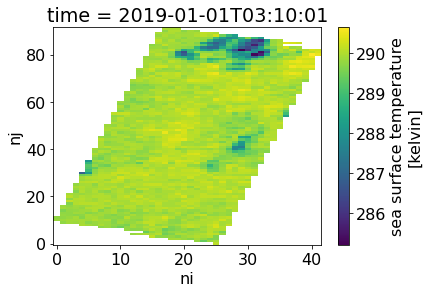

In [31]:
with xr.open_dataset(test_download) as ds:
    ds.sea_surface_temperature[0].plot()

#### Download all the netCDF subsets

Get the links in the *href* column in a loop:

In [32]:
subsets['path'] = subsets.href.progress_apply(download_target_file)

os.path.isfile(subsets.path.iloc[0])

100%|██████████| 74/74 [00:00<00:00, 48648.67it/s]


True

#### Limit to daytime MODIS observations

Select just the *daytime* observations into a new data frame. (Remember we added a *daytime* column during a previous step.)

In [33]:
subsets_day = subsets[subsets.daytime==True].copy()

print(subsets_day.index.size, "of", subsets.index.size, "MODIS acquisitions were collected during the daytime.")

37 of 74 MODIS acquisitions were collected during the daytime.


#### Data quality

The *quality_level* variable describes the observation quality for each pixel in the L2 swaths. Values are assigned between 1 and 6 corresponding to these quality levels:

1. no_data
2. bad_data
3. worst_quality
4. low_quality
5. acceptable_quality
6. best_quality

The next cell plots the masked SST grid for the first daytime observations:

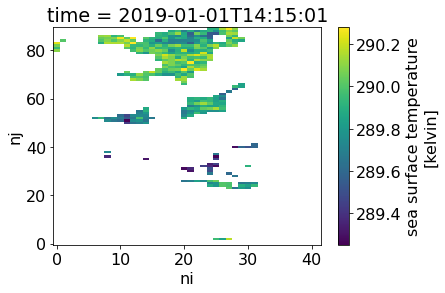

In [34]:
with xr.open_dataset(subsets_day.iloc[0].path) as ds:

    # Create a mask for pixels with acceptable quality or better:
    quality_mask = ds.quality_level[0]>=5

    # Fill the unqualified pixels with values of 'np.nan':
    masked_ds = ds.where(quality_mask)

    # Plot resulting masked sea surface temperature array:
    masked_ds.sea_surface_temperature[0].plot()

### Plot time series from multiple data sources

Roll the logic above into a few map-able functions that group the SST data by day to produce (up to) one daily mean.

>#### Apply filter and mean in two functions
>
>`get_user_stat` reads the input netCDF and applies some user-specified function to the dataset to render the desired output, then closes the file.
>
>The second function `_masked_mean` filters and calculates the XY mean of the *sea_surface_temperature* variable. (You could replace this function with your own to do something different.)

Test the combined routine against the first file in the daytime MODIS table:

In [35]:
def get_user_stat(netcdf, function):
    with xr.open_dataset(netcdf) as ds:  
        output = function(ds)
    return output

def _masked_mean(dataset):
    masked = dataset.where(dataset.quality_level[0]>=5)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        value = masked.sea_surface_temperature.mean(['nj','ni']).data.item()
    return value

get_user_stat(subsets_day.path.iloc[0], function=_masked_mean) - 273.15

16.743005371093773

That should give a reasonable value in degrees Celsius.

##### Get means for the filtered MODIS SST time series in a new column

Apply the `_masked_mean` function over the column of subsets (i.e. netCDF4 files) to get the time series in a new column *sst_mean*:

In [36]:
subsets_day['sst_mean'] = subsets_day.path.apply(get_user_stat, args=(_masked_mean,)) - 273.15

subsets_day['sst_mean'].describe()

count    15.000000
mean     16.404915
std       0.566561
min      15.284357
25%      15.921838
50%      16.546533
75%      16.833688
max      17.222162
Name: sst_mean, dtype: float64

We may need to group by the date:

In [37]:
subsets_day_means = subsets_day.groupby("date", as_index=False).mean()

subsets_day_means.describe()

,sst_mean
count,15.000000
mean,16.404915
std,0.566561
min,15.284357
25%,15.921838
50%,16.546533
75%,16.833688
max,17.222162


Now plot the two time series along the same *date* axis for visual comparison:

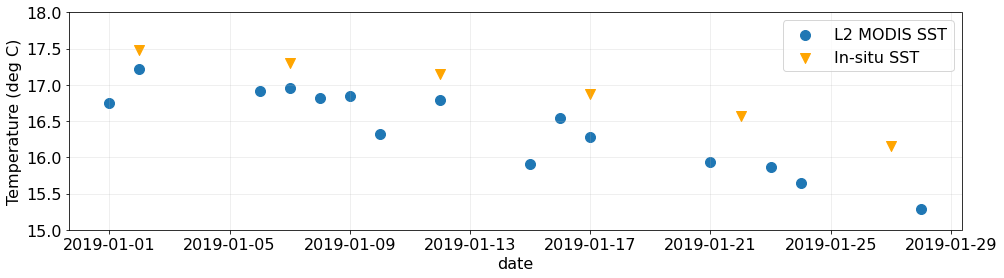

In [38]:
fig, ax = plt.subplots(figsize=(16, 4))

# Mean sea surface temperature from MODIS/GHRSST:
subsets_day_means.plot.scatter(x="date",
                               y="sst_mean", 
                               label="L2 MODIS SST",
                               s=100,
                               ax=ax)

# Mean sea surface temperature from Argo floats:
argo_skinny.plot.scatter(x="date",
                         y="temp_at_pres_min",
                         s=100,
                         color="orange",
                         marker="v",
                         label="In-situ SST",
                         ax=ax)

ax.set_ylabel("Temperature (deg C)")
ax.set_ylim(15.0, 18.0)
ax.grid(alpha=0.25)

### MUR Level 4 SST from AWS Open Registry

Try plotting the summarized time series for the two datasets against MUR L4 SST from AWS Open Registry: https://registry.opendata.aws/mur/

In [39]:
%%time
import fsspec
import xarray as xr
from dask.distributed import Client

fs = fsspec.get_mapper('s3://mur-sst/zarr', anon=True)

ds = xr.open_zarr(fs, consolidated=True)

sst = ds['analysed_sst'].sel(time=slice(start_date, end_date),
                             lat=slice(aoi_lat_min, aoi_lat_max), 
                             lon=slice(aoi_lon_min, aoi_lon_max), ).persist()

sst_mean = sst.groupby("time").mean(["lon", "lat"]) - 273.15

print(sst_mean)

<xarray.DataArray 'analysed_sst' (time: 31)>
dask.array<sub, shape=(31,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-31T09:00:00
CPU times: user 6.03 s, sys: 860 ms, total: 6.89 s
Wall time: 8.05 s


Add the MUR time series to the subsets table so that they share the same time axis with the L2 time series:

In [40]:
subsets_day_means['L4_MUR_SST'] = sst_mean.compute().data

Plot the result alongside our data processed throughout the notebook:

Text(0.5, 1.0, 'Daily SST from L2 MODIS, L4 MUR, and in-situ measurements (Jan 2019)')

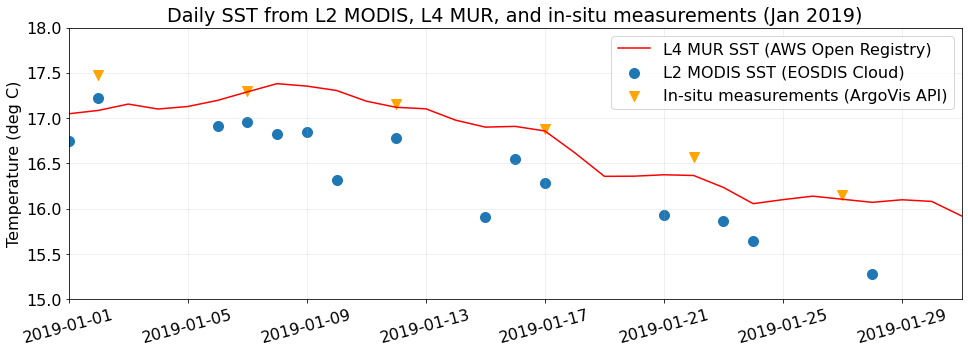

In [41]:
fig, ax = plt.subplots(figsize=(16, 5))

# L4 MUR SST from AWS Open Registry:
subsets_day_means.plot.line(x="date",
                            y="L4_MUR_SST",
                            color="red",
                            label="L4 MUR SST (AWS Open Registry)",
                            ax=ax)

# L2 MODIS SST from Harmony API:
subsets_day_means.plot.scatter(x="date",
                               y="sst_mean", 
                               label="L2 MODIS SST (EOSDIS Cloud)",
                               s=100,
                               ax=ax)

# In-situ SST from ArgoVis API:
argo_skinny.plot.scatter(x="date",
                         y="temp_at_pres_min",
                         s=100,
                         color="orange",
                         marker="v",
                         label="In-situ measurements (ArgoVis API)",
                         ax=ax)

plt.xticks(rotation=15)
ax.set_xlabel(None)
ax.set_xlim(subsets_day_means.date.iloc[0], subsets_day_means.date.iloc[-1])
ax.set_ylabel("Temperature (deg C)")
ax.set_ylim(15.0, 18.0)
ax.grid(alpha=0.25)
ax.set_title("Daily SST from L2 MODIS, L4 MUR, and in-situ measurements (Jan 2019)")

## Results

The size of the L2 MODIS subsets in total and individually:

In [42]:
!du -sh resources/data

8.9M	resources/data


In [43]:
!du -sh resources/data/*subsetted.nc4

136K	resources/data/20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
124K	resources/data/20190101141501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
128K	resources/data/20190102021501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
116K	resources/data/20190102132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
140K	resources/data/20190103030000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
120K	resources/data/20190103140501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
124K	resources/data/20190104020501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
120K	resources/data/20190104034001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
124K	resources/data/20190104034501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
108K	resources/data/20190104131001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
108K	resources/data/20190104144501-JPL-L2P_GHRSST-

## Next steps

Check performance of direct s3 access to MUR from PO.DAAC archive in netCDF format:

In [44]:
import s3fs

def begin_s3_direct_access(url="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

cloud = os.path.join("podaac-ops-cumulus-protected/", "MUR-JPL-L4-GLOB-v4.1/", "*201901*.nc")

files = fs.glob(cloud)

print(len(files))

31


In [45]:
%%time

var  = ['analysed_sst', 'mask']
lats = [aoi_lat_min, aoi_lat_max]
lons = [aoi_lon_min, aoi_lon_max]

mur = xr.open_mfdataset(
    paths=[fs.open(f) for f in files],
    combine='by_coords',
    engine='h5netcdf',
    chunks='auto',
    cache=False,
    decode_cf=True,
    mask_and_scale=True,
    preprocess=lambda x: x[var].sel(lat=slice(*lats), lon=slice(*lons)))

print(mur)

<xarray.Dataset>
Dimensions:       (time: 31, lat: 78, lon: 45)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-31T09...
  * lat           (lat) float32 37.71 37.72 37.73 37.74 ... 38.46 38.47 38.48
  * lon           (lon) float32 -13.26 -13.25 -13.24 ... -12.84 -12.83 -12.82
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 78, 45), meta=np.ndarray>
    mask          (time, lat, lon) float32 dask.array<chunksize=(1, 78, 45), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:             

In [46]:
%%time

sst_mean = mur.analysed_sst.groupby("time").mean(["lon","lat"]) - 273.15

print(sst_mean)

<xarray.DataArray 'analysed_sst' (time: 31)>
dask.array<sub, shape=(31,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-31T09:00:00
CPU times: user 63.7 ms, sys: 3.85 ms, total: 67.5 ms
Wall time: 66.2 ms


CPU times: user 4.2 s, sys: 773 ms, total: 4.97 s
Wall time: 22.1 s


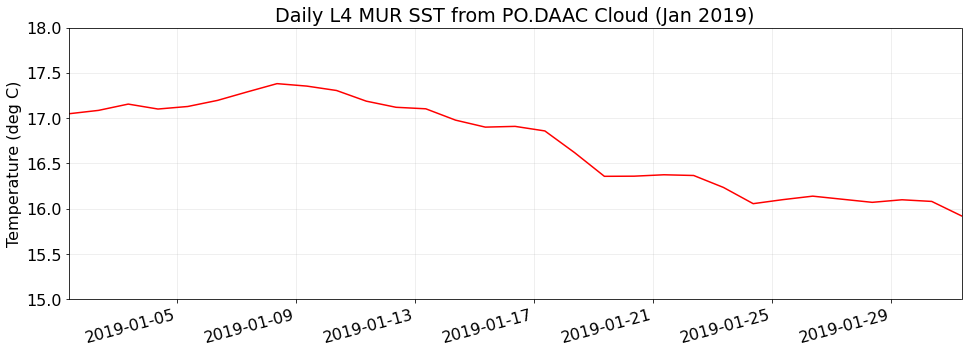

In [47]:
%%time

fig, ax = plt.subplots(figsize=(16, 5))

sst_mean.compute().plot(ax=ax, color="red")

plt.xticks(rotation=15)
ax.set_xlim(sst_mean.time.min(), sst_mean.time.max())
ax.set_xlabel(None)
ax.set_ylim(15.0, 18.0)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Daily L4 MUR SST from PO.DAAC Cloud (Jan 2019)")
ax.grid(alpha=0.25)

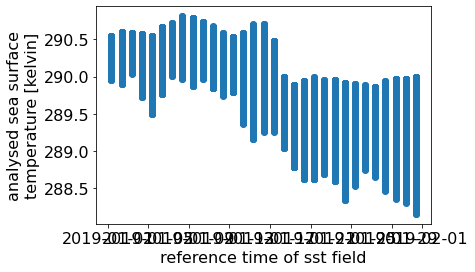

In [48]:
mur.plot.scatter("time", "analysed_sst", figsize=(16, 5))